In [11]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pylab as plt
import sys
from PIL import Image
sys.modules['Image'] = Image 

# Dataset

In [13]:
all_data=glob("/Users/weiminliu/Downloads/archive/**/*.png",recursive = True)

In [14]:
for e in all_data[:3]:
    print(e)

#create empty list
cancer=[] 
no_cancer=[]

#create loop
for d in all_data:
    if d[-5]=="0":
        no_cancer.append(d)
    elif d[-5] =='1':
        cancer.append(d)

/Users/weiminliu/Downloads/archive/9036/0/9036_idx5_x1051_y2401_class0.png
/Users/weiminliu/Downloads/archive/9036/0/9036_idx5_x2951_y951_class0.png
/Users/weiminliu/Downloads/archive/9036/0/9036_idx5_x3001_y1451_class0.png


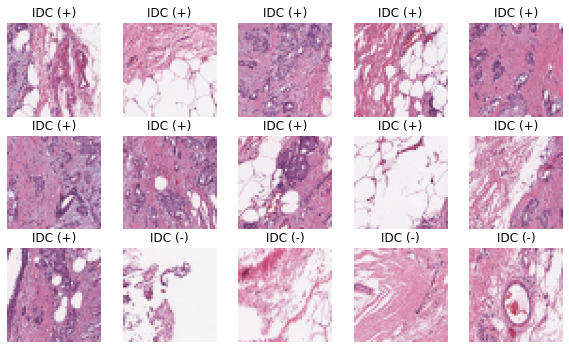

In [15]:
plt.figure(figsize=(10,10))
for e in range(1,len(no_cancer[:12])):
    plt.subplot(5,5,e+4)
    plt.axis('off')
    plt.title('IDC (-)')
    imt = image.load_img(no_cancer[e],target_size=(100,100))
    imt = image.img_to_array(imt)                     
    plt.imshow(imt.astype('uint8'))
    
    
for e in range(1,len(cancer[:12])):
    plt.subplot(5,5,e)
    plt.axis('off')
    plt.title('IDC (+)')
    imag = image.load_img(cancer[e],target_size=(100,100))
    imag = image.img_to_array(imag)                     
    plt.imshow(imag.astype('uint8'))

## Preprocess

In [16]:
from matplotlib.image import imread
import cv2
non_image_cancer=[]
image_cancer=[]

In [17]:
#sample
cancer= random.sample(cancer, 20000)
no_cancer= random.sample(no_cancer, 20000)

In [18]:
#creating loop & label 
for g in no_cancer:
    number_image=cv2.imread(g,cv2.IMREAD_COLOR)

    image_size=cv2.resize(number_image,(50,50),interpolation = cv2.INTER_LINEAR)
    non_image_cancer.append([image_size,0])

In [19]:
# creating loop &label 
for g in cancer:
    number_image=cv2.imread(g,cv2.IMREAD_COLOR)
    image_size=cv2.resize(number_image,(50,50),interpolation = cv2.INTER_LINEAR)
    image_cancer.append([image_size,1])

In [20]:
# create empty list
x=[]
y=[]

In [21]:
#transform to array
import numpy as np
breast_image_array=np.concatenate((image_cancer,non_image_cancer))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [22]:
#import random
import random
random.shuffle(breast_image_array)
for feature,label in breast_image_array:
    x.append(feature)
    y.append(label)

In [23]:
#create array to see shape
x=np.array(x)
y=np.array(y)
x.shape

(40000, 50, 50, 3)

In [24]:
y.shape

(40000,)

## Split train and test

In [25]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_predict, y_train, y_true = train_test_split(x, y, test_size = 0.3)
rate = 0.5
num = int(x.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (20000, 50, 50, 3)
X_test shape : (8000, 50, 50, 3)
X_predict shape : (12000, 50, 50, 3)
y_train shape : (20000, 2)
y_test shape : (8000, 2)


In [26]:
def plot_model_parameters(history): 
    plt.figure(1, figsize = (20, 6))
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize = 16)
    plt.ylabel('loss', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('accuracy', fontsize = 16)
    plt.xlabel('epoch', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
    
    plt.show()
    plt.savefig('loss_and_accuracy', dpi = 300)

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load in VGG-16 model with weights pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# Make sure the correct layers are frozen
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

2021-10-19 21:35:12.918285: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [28]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(2, activation = 'softmax')(x) # Softmax for multiclass

transfer_model = Model(inputs=vgg_model.input, outputs = x)

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.6, 
                              patience = 8, 
                              verbose = 1, 
                              mode = 'max', 
                              min_lr = 5e-5)

checkpoint = ModelCheckpoint('vgg16_finetune_1.h15', 
                             monitor = 'val_accuracy', 
                             mode = 'max', 
                             save_best_only = True, 
                             verbose = 1)

In [30]:
from tensorflow.keras import layers, models, Model, optimizers

learning_rate = 5e-5

transfer_model.compile(loss = "categorical_crossentropy", 
                       optimizer = optimizers.Adam(lr = learning_rate), 
                       metrics = ["accuracy"])

history_vgg = transfer_model.fit(X_train, y_train, batch_size = 16, 
                                 epochs = 50, validation_data = (X_test,y_test), callbacks=[lr_reduce,checkpoint])

Train on 20000 samples, validate on 8000 samples
Epoch 1/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8415
Epoch 00001: val_accuracy improved from -inf to 0.86900, saving model to vgg16_finetune_1.h15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-10-19 21:58:38.397307: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: vgg16_finetune_1.h15/assets
20000/20000 [==============================] - 1370s 69ms/sample - loss: 0.4024 - accuracy: 0.8416 - val_loss: 0.3232 - val_accuracy: 0.8690
Epoch 2/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8655
Epoch 00002: val_accuracy improved from 0.86900 to 0.87663, saving model to vgg16_finetune_1.h15
INFO:tensorflow:Assets written to: vgg16_finetune_1.h15/assets
20000/20000 [==============================] - 1356s 68ms/sample - loss: 0.2921 - accuracy: 0.8654 - val_loss: 0.2599 - val_accuracy: 0.8766
Epoch 3/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.8957
Epoch 00003: val_accuracy improved from 0.87663 to 0.90013, saving model to vgg16_finetune_1.h15
INFO:tensorflow:Assets written to: vgg16_finetune_1.h15/assets
20000/20000 [==============================] - 1339s 67ms/sample - loss: 0.2438 - accuracy: 0.8957 - val_loss: 0.2423 - val_accuracy: 0

Epoch 27/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9962
Epoch 00027: val_accuracy improved from 0.93050 to 0.93238, saving model to vgg16_finetune_1.h15
INFO:tensorflow:Assets written to: vgg16_finetune_1.h15/assets
20000/20000 [==============================] - 1373s 69ms/sample - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.5407 - val_accuracy: 0.9324
Epoch 28/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9968
Epoch 00028: val_accuracy did not improve from 0.93238
20000/20000 [==============================] - 1375s 69ms/sample - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.4832 - val_accuracy: 0.9324
Epoch 29/50
19984/20000 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9971
Epoch 00029: val_accuracy did not improve from 0.93238
20000/20000 [==============================] - 1334s 67ms/sample - loss: 0.0112 - accuracy: 0.9972 - val_loss: 0.8142 - val_accuracy: 0.9082
Epoc

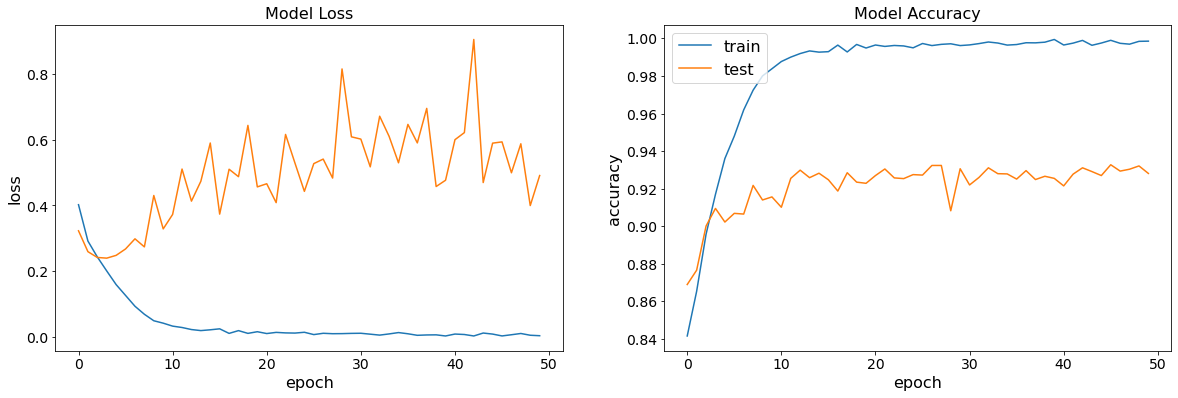

<Figure size 432x288 with 0 Axes>

In [31]:
plot_model_parameters(history_vgg)

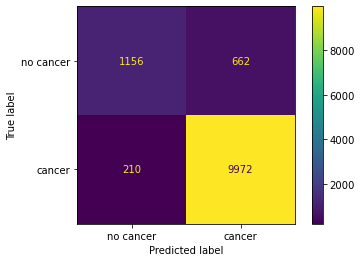

<Figure size 432x288 with 0 Axes>

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#tensorflow.cast(X_predict, tensorflow.float32)
y_pred = transfer_model.predict(tensorflow.cast(X_predict, tensorflow.float32))
y_pred_labels = np.argmax(y_pred, axis = 1)
y_true_labels = np.argmax(y_true, axis = 1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['no cancer', 'cancer'])
disp.plot()
plt.show()
plt.savefig('confusion_matrix', dpi = 300)

In [35]:
Precision=9972/(9972+662)
Precision

0.9377468497272898

In [36]:
Recall=9972/(9972+210)
Recall

0.9793753682969947

In [37]:
F1=2* ((Recall * Precision) / (Recall+Precision))
F1

0.9581091468101461